In [1]:
library(ggplot2)
library(data.table)
library(dplyr)
library(tidyr)
library(purrr) 
library(scales)
if (!require(extrafont)) install.packages("extrafont")
library(extrafont)

# 3. 폰트 로드
loadfonts()


다음의 패키지를 부착합니다: ‘dplyr’


The following objects are masked from ‘package:data.table’:

    between, first, last


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



다음의 패키지를 부착합니다: ‘purrr’


The following object is masked from ‘package:data.table’:

    transpose



다음의 패키지를 부착합니다: ‘scales’


The following object is masked from ‘package:purrr’:

    discard


필요한 패키지를 로딩중입니다: extrafont

Registering fonts with R

cmex10 already registered with pdfFont().

cmmi10 already registered with pdfFont().

cmr10 already registered with pdfFont().

cmsy10 already registered with pdfFont().

DejaVu Sans already registered with pdfFont().

DejaVu Sans Condensed already registered with pdfFont().

DejaVu Sans Light already registered with pdfFont().

esint10 already registered with pdfFont().

eufm10 already registered with pdfFont().

Liberation Mono already registered with pdfF

In [4]:
cohort <- "UKB" # UKB, GS, simulation
e_level <- 5 # simulation에서 사용

# Load data

In [5]:
# 방법 1: paste0() 사용
frreg_path <- paste0(
    "/data/jerrylee/pjt/BIGFAM.v.2.0/data/", 
    cohort, 
    "/obj1/slope-test"
)

# .slope 파일 리스트 불러오기
files_list <- list.files(
    path = frreg_path, 
    pattern = "\\.slope$",  
    full.names = TRUE
) %>% 
    # .raw.slope 파일 제외
    .[!grepl("\\.raw\\.slope$", .)]

# simulation 코호트일 경우에만 e_level 파일 필터링
if (cohort == "simulation") {
    error_fn <- paste0("-e_", e_level, ".")
    files_list <- files_list[grepl(error_fn, files_list)]
}

length(files_list)

[1] 106

In [13]:
# 모든 .slope 파일 읽고 원하는 형태로 가공하기
df_combined <- files_list %>%
    # 각 파일을 읽어서 리스트로 만들기
    map(function(file) {
        # 파일명에서 pheno 이름 추출 (첫번째 '.' 이전까지의 문자열)
        pheno <- basename(file) %>%
            strsplit("\\.") %>%
            .[[1]] %>%
            .[2]
        
        # 파일 읽기
        df <- fread(file)
        
        # slope와 intercept의 median 값 추출
        slope_val <- df[param == "slope", median]
        intercept_val <- df[param == "intercept", median]
        
        # significant 판단
        slope_lower <- df[param == "slope", `lower(2.5%)`]
        slope_upper <- df[param == "slope", `upper(97.5%)`]
        
        significant <- case_when(
            slope_lower > 1 ~ "Fast",
            slope_upper < 1 ~ "Slow",
            TRUE ~ "Similar"
        )
        
        # 데이터프레임 생성
        data.frame(
            pheno = pheno,
            slope = slope_val,
            intercept = intercept_val,
            significant = significant
        )
    }) %>%
    # 모든 데이터프레임 합치기
    bind_rows()

head(df_combined)

,pheno,slope,intercept,significant
,<chr>,<dbl>,<dbl>,<chr>
1,abpi,0.4934937,-3.0806875,Similar
2,avg_dia,0.5759438,-2.7393497,Similar
3,avg_hr,0.5010706,-2.5668180,Slow
4,avg_sys,0.7245335,-2.7345967,Similar
5,Creat_mgdl,0.6953570,-0.8745035,Slow
6,Creatinine,0.7379110,-0.7467509,Slow


# plot theme

In [14]:
# 공통 테마 함수 정의
get_nature_theme <- function() {
    theme_bw() +
        theme(
            # 전체적인 배경
            panel.background = element_rect(fill = NA, color = NA),
            panel.grid.major = element_blank(),
            panel.grid.minor = element_blank(),
            panel.border = element_rect(color = "black", fill = NA, size = 0.6),  # size로 선 굵기 조절
            
            # panel.border = element_blank(),  
            
            # 축 설정
            # axis.line.x.top = element_line(color = "black", size = 0.3),  
            # axis.line.y.right = element_line(color = "black", size = 0.3),  
            # axis.line.x.bottom = element_line(color = "black", size = 0.3),  
            # axis.line.y.left = element_line(color = "black", size = 0.3),    
            axis.text = element_text(size = 6.5, color = "black"),
            axis.title = element_text(size = 7.5, color = "black"),
            axis.ticks = element_line(size = 0.3),
            axis.ticks.length = unit(0.8, "mm"),
            
            # 메인 figure에 박스 추가
            # plot.background = element_rect(color = "black", fill = NA),
            
            # legend 박스 제거
            legend.box.background = element_blank(),  # 이전: element_rect(color = "black")
            
            # 범례 설정
            legend.margin = margin(1, 1, 1, 1, unit = "mm"),
            # legend.spacing.y = unit(0.1, "cm"),
            
            # 여백 설정
            # plot.margin = unit(c(0.1, 0.2, 0.1, 0.1), "cm")
            plot.margin = margin(0.1, 0.1, 0.1, 0.1, unit = "mm")
        )
}

# 공통 색상 정의
color_values <- c(
    "Fast" = "#E64B35",
    "Slow" = "#4DBBD5",
    "Similar" = "#7E7E7E"
)

# Step 1. Real data

In [15]:
plot_slope_intercept <- function(data, figure_tag = NULL) {
    p <- ggplot(data, aes(x = intercept, y = slope)) +
        # point plot
        geom_point(aes(fill = significant),
                  size = 2, 
                  alpha = 0.8,
                  shape = 21,
                  stroke = 0.3,
                  color = "grey50") +
        # fill & legend
        scale_fill_manual(
            values = color_values,
            name = "Decaying",
            guide = guide_legend(
                override.aes = list(
                    shape = 21,
                    color = "white",
                    size = 2.5
                ),
                keywidth = unit(1, "mm"),
                keyheight = unit(1, "mm"),
                spacing.y = unit(10, "mm")
            )
        ) +
        geom_hline(yintercept = 1, linetype = "dashed", 
                   color = "black", size = 0.2, alpha = 0.5) +
        labs(
            x = "Intercept",
            y = "Slope"
        ) +
        # scale_x_continuous(
        #     breaks = scales::pretty_breaks(),
        #     limits = c(-4, 0)
        # ) +
        # scale_y_continuous(
        #     breaks = scales::pretty_breaks(),
        #     limits = c(0.6, 1.4)) +
        get_nature_theme() + 
        # legend 전체
        theme(
            legend.position = "right", #c(0.8, 0.5),  # x, y 위치 (0-1 사이 값)
            # legend.justification = c(0, 0.5),    # 좌측 상단 기준 정렬
            legend.box.margin = margin(0, 0, 0, 0, unit = "mm"),
            legend.spacing.x = unit(0, "mm"),  # figure와 legend 사이 간격
            # legend.box.background = element_rect(color = "black"),
            legend.background = element_rect(fill = NA, color = NA),
            legend.title = element_text(size = 7),
            legend.text = element_text(size = 7),      # 범례 텍스트 크기
            legend.key.size = unit(0.5, "lines"),
            legend.key.height = unit(0.5, "lines"),
            legend.key.width = unit(0.5, "lines"),
            plot.margin = margin(1, 0, 0, 0, "mm")
        )
    
    if (!is.null(figure_tag)) {
        p <- p + 
            annotate("text", x = -Inf, y = Inf, 
                    label = figure_tag, 
                    hjust = -0.2, vjust = 1.5,
                    size = 3)
    }
    
    return(p)
}

In [20]:
# significant 그룹별 개수 확인
df_combined %>%
  group_by(significant) %>%
  summarise(count = n()) %>%
  arrange(desc(count))

significant,count
<chr>,<int>
Similar,15
Slow,9


In [21]:
df_combined %>% filter(slope < 0)

pheno,slope,intercept,significant
<chr>,<dbl>,<dbl>,<chr>


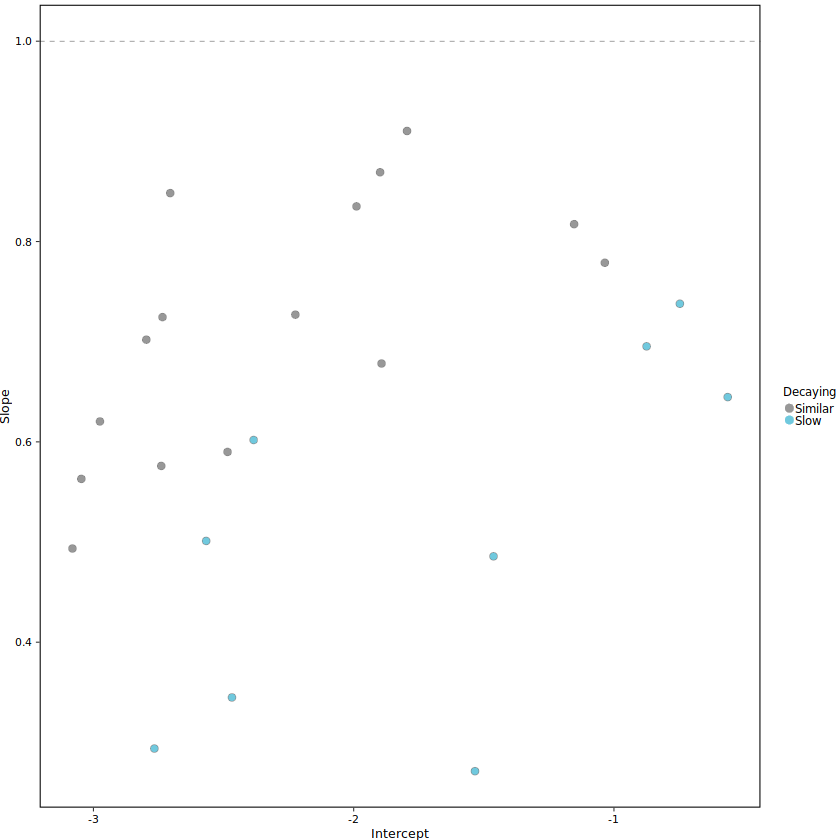

In [22]:
# 함수 사용 예시:
# 플롯만 보기
p <- plot_slope_intercept(
    data = df_combined
)
print(p)

# # 파일 저장과 함께 사용
# output_path <- paste0(
#     "/data/jerrylee/pjt/BIGFAM.v.2.0/figures/", 
#     cohort, 
#     ".slope-test.pdf"
# )

# ggsave(
#     filename = output_path,
#     plot = p,
#     width = 65,
#     height = 45,
#     units = "mm",
#     dpi = 300
# )

# Step 2. simulation plot

In [85]:
# true significant 값 추출 함수 수정
get_true_significant <- function(pheno) {
    w_value <- as.numeric(gsub(".*w_(\\d+).*", "\\1", pheno)) / 1000
    case_when(
        w_value < 1 ~ "Increase",
        w_value >= 1 & w_value < 1.8 ~ "Slow",
        w_value >= 1.8 & w_value <= 2.2 ~ "Similar",
        w_value > 2.2 ~ "Fast",
        TRUE ~ NA_character_    # 예외 케이스 처리
    )
}

# 데이터에 true significant 추가
df_simul_combined <- df_combined %>%
    mutate(
        true_significant = sapply(pheno, get_true_significant),
        match_result = true_significant == significant
    )

# factor 레벨 설정 및 NA 제거
df_simul_combined <- df_simul_combined %>%
    mutate(
        true_significant = factor(true_significant, 
                                levels = c("Fast", "Slow", "Increase", "Similar")),
        significant = factor(significant, 
                           levels = c("Fast", "Slow", "Increasing", "Similar"))
    ) %>%
    filter(!is.na(slope), 
           !is.na(intercept),
           !is.na(true_significant),
           !is.na(significant))

# 결과 확인
head(df_simul_combined)

,pheno,slope,intercept,significant,true_significant,match_result
,<chr>,<dbl>,<dbl>,<fct>,<fct>,<lgl>
1,G_140-S_109-w_1152-e_5,0.4231007,-2.063328,Slow,Slow,TRUE
2,G_140-S_109-w_1152-e_50,0.2971038,-2.241941,Similar,Slow,FALSE
3,G_140-S_109-w_1178-e_5,0.4390127,-2.054435,Slow,Slow,TRUE
4,G_140-S_109-w_1178-e_50,0.4607094,-1.989773,Similar,Slow,FALSE
5,G_140-S_109-w_1236-e_5,0.5134697,-1.955073,Slow,Slow,TRUE
6,G_140-S_109-w_1236-e_50,0.5887660,-2.012110,Similar,Slow,FALSE


In [92]:
# 두 번째 함수 수정
plot_slope_intercept_comparison <- function(data) {
    # 데이터 정렬: similar를 마지막에 그리도록 순서 변경
    data <- data %>%
        arrange(desc(significant == "Similar"))
    
    # shape 정의
    shape_values <- c(
        "Fast" = 24,
        "Slow" = 25,
        "Similar" = 21,
        "Increase" = 22
    )
    
    ggplot(data, aes(x = intercept, y = slope)) +
        geom_point(aes(shape = true_significant,
                      fill = significant,
                      color = NA),
                  size = 2,
                  stroke = 0.3,
                  alpha = 0.8) +
        scale_fill_manual(
            values = color_values,
            guide = guide_legend(
                override.aes = list(
                    shape = 21,
                    color = "white",
                    size = 2.5  # fill legend 크기를 shape legend와 맞춤
                ),
                keywidth = unit(0.5, "lines"),
                keyheight = unit(0.5, "lines")
            )
        ) +
        scale_shape_manual(
            values = shape_values,
            guide = guide_legend(
                override.aes = list(
                    size = 1.5  # shape legend 크기 설정
                ),
                keywidth = unit(0.5, "lines"),
                keyheight = unit(0.5, "lines")
            )
        ) +
        scale_color_manual(values = c("black" = "black"),
                          guide = "none") +
        geom_hline(yintercept = 1, 
                   linetype = "dashed", 
                   color = "black", 
                   size = 0.2) +
        labs(
            x = "Intercept",
            y = "Slope",
            shape = "Decaying (True)",
            fill = "Decaying (Test)"
        ) +
        scale_x_continuous(
            breaks = scales::pretty_breaks(),
            limits = c(-5, 1)
        ) +
        scale_y_continuous(
            breaks = scales::pretty_breaks(),
            limits = c(-2, 2)) +
        get_nature_theme() + 
        # legend 전체
        theme(
            # legend.position = "right", #c(0.8, 0.5),  # x, y 위치 (0-1 사이 값)
            # # legend.justification = c(0, 0.5),    # 좌측 상단 기준 정렬
            # legend.box.margin = margin(0, 0, 0, 0, unit = "mm"),
            # legend.box.background = element_rect(color = "black"),
            # legend.background = element_rect(fill = NA, color = NA),
            # legend.title =  element_text(size = 6), 
            # legend.text = element_text(size = 6.5),      # 범례 텍스트 크기
            # legend.key.size = unit(0.5, "lines"),
            # legend.key.height = unit(0.5, "lines"),
            # legend.key.width = unit(0.5, "lines"),
            # plot.margin = margin(0, 0, 0, 0, "mm"),
            # legend.spacing.y = unit(1, "mm")

            legend.position = "right", #c(0.8, 0.5),  # x, y 위치 (0-1 사이 값)
            # legend.justification = c(0, 0.5),    # 좌측 상단 기준 정렬
            legend.box.margin = margin(0, 0, 0, 0, unit = "mm"),
            legend.spacing.x = unit(0, "mm"),  # figure와 legend 사이 간격
            # legend.box.background = element_rect(color = "black"),
            legend.background = element_rect(fill = NA, color = NA),
            legend.title = element_text(size = 7),
            legend.text = element_text(size = 7),      # 범례 텍스트 크기
            legend.key.size = unit(0.5, "lines"),
            legend.key.height = unit(0.5, "lines"),
            legend.key.width = unit(0.5, "lines"),
            plot.margin = margin(1, 0, 0, 0, "mm")

        )
}

In [ ]:
# random sampling for better visualization
for_plot <- bind_rows(
  df_simul_combined %>% 
    filter(true_significant == "Slow") %>% 
    sample_n(200),
  
  df_simul_combined %>% 
    filter(true_significant == "Similar") %>% 
    sample_n(30),
  
  df_simul_combined %>% 
    filter(true_significant == "Fast") %>% 
    sample_n(150),
  
  df_simul_combined %>% 
    filter(true_significant == "Increase") %>% 
    sample_n(70)
)

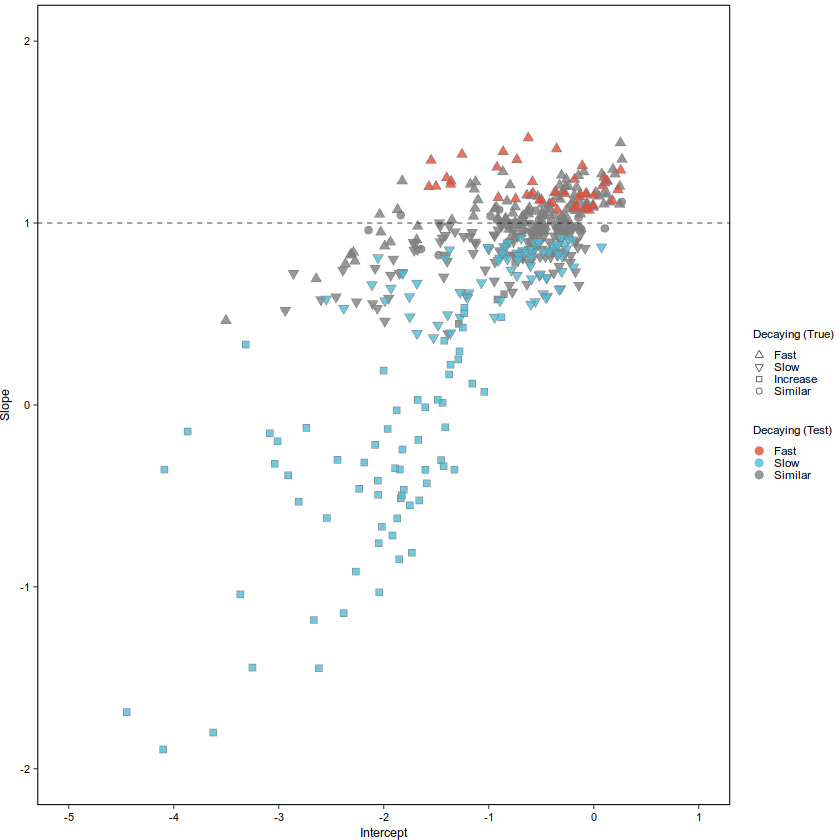

In [98]:
p <- plot_slope_intercept_comparison(for_plot)
print(p)

# PDF로 저장
output_path <- paste0(
    "/data/jerrylee/pjt/BIGFAM.v.2.0/figures/", 
    cohort, 
    ".slope-test.pdf"
)

ggsave(
    filename = output_path,
    plot = p,
    width = 70,
    height = 45,
    units = "mm",
    dpi = 300
)

## colored by other variables

In [21]:
for_plot <- df_simul_combined %>% 
    mutate(
        # G 값 추출 및 변환
        G = as.numeric(gsub(".*G_(\\d+).*", "\\1", pheno)) / 1000,
        # S 값 추출 및 변환
        S = as.numeric(gsub(".*S_(\\d+).*", "\\1", pheno)) / 1000,
        # w 값 추출 및 변환
        w = as.numeric(gsub(".*w_(\\d+).*", "\\1", pheno)) / 1000
    ) %>% 
    filter(true_significant == "increasing") %>%
    sample_n(500) 

# 결과 확인
head(for_plot)

,pheno,slope,intercept,significant,true_significant,match_result,G,S,w
,<chr>,<dbl>,<dbl>,<fct>,<fct>,<lgl>,<dbl>,<dbl>,<dbl>
1,G_706-S_67-w_749-e_50,0.51931204,-0.7628722,slow,increasing,FALSE,0.706,0.067,0.749
2,G_209-S_168-w_232-e_5,-1.76468247,-3.7267362,slow,increasing,FALSE,0.209,0.168,0.232
3,G_765-S_109-w_628-e_50,0.18001128,-0.9475690,slow,increasing,FALSE,0.765,0.109,0.628
4,G_140-S_65-w_628-e_50,-0.15975207,-2.9997123,slow,increasing,FALSE,0.140,0.065,0.628
5,G_209-S_44-w_628-e_5,0.05059197,-2.7672438,slow,increasing,FALSE,0.209,0.044,0.628
6,G_612-S_50-w_519-e_5,0.22122082,-1.3633377,slow,increasing,FALSE,0.612,0.050,0.519


In [22]:
#  플롯 함수 정의
plot_slope_intercept <- function(data, color_var) {
    # 입력된 변수명이 데이터에 있는지 확인
    if (!color_var %in% names(data)) {
        stop(paste("변수", color_var, "가 데이터에 존재하지 않습니다."))
    }
    
    # 마커 스타일 정의
    shape_values <- c(
        "fast" = 24,      # 위쪽 삼각형
        "slow" = 25,      # 아래쪽 삼각형
        "similar" = 21,   # 원형
        "increasing" = 22 # 사각형
    )
    
    # 동적으로 fill과 size 매핑 생성
    mapping <- aes_string(x = "intercept", 
                         y = "slope",
                         fill = color_var,
                         shape = "true_significant",
                         size = "significant")
    
    # 플롯 생성
    p <- ggplot(data, mapping) +
        geom_point(stroke = 0.3,
                  alpha = 0.8) +
        scale_fill_gradient(
            low = "#4DBBD5",    # 낮은 값: 밝은 파란색
            high = "#E64B35"    # 높은 값: 밝은 빨간색
        ) +
        scale_shape_manual(
            values = shape_values,
            guide = guide_legend(
                title = "True Pattern",
                override.aes = list(
                    size = 2,
                    fill = "grey50"
                )
            )
        ) +
        scale_size_manual(
            values = c(
                "similar" = 1,     # similar는 작게
                "fast" = 5,        # 나머지는 크게
                "slow" = 5
            ),
            guide = "none"
        ) +
        geom_hline(yintercept = 1, 
                   linetype = "dashed", 
                   color = "black", 
                   size = 0.2) +
        labs(
            x = "Intercept",
            y = "Slope",
            fill = color_var
        ) +
        get_nature_theme()
    
    return(p)
}

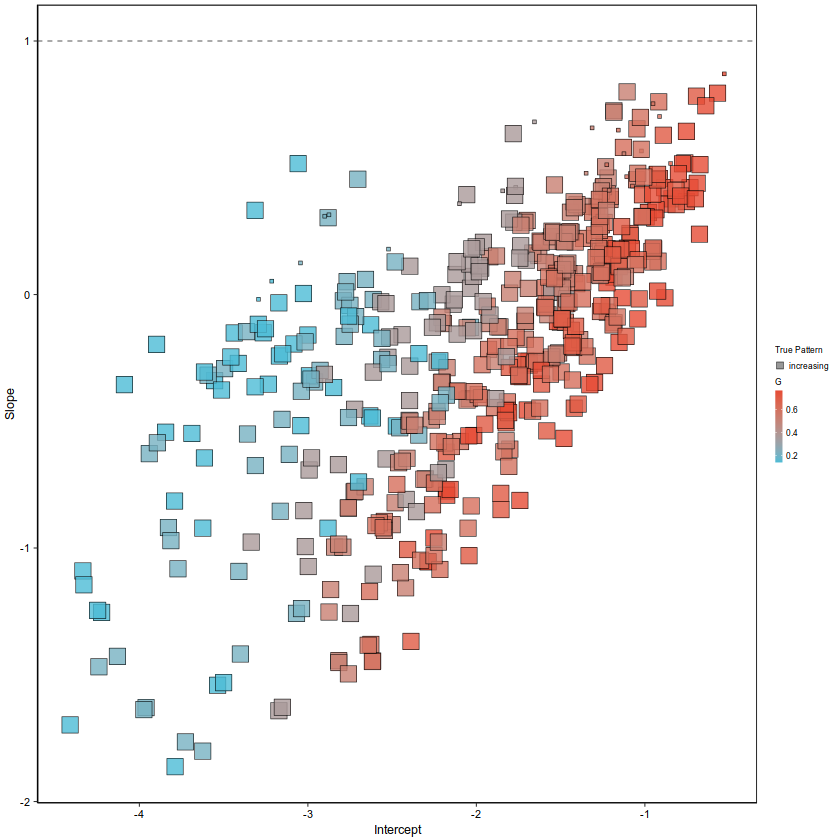

In [23]:
# G 값으로 색상 표시
p1 <- plot_slope_intercept(for_plot, "G")
print(p1)

# # S 값으로 색상 표시
# p2 <- plot_slope_intercept(for_plot, "S")

# # w 값으로 색상 표시
# p3 <- plot_slope_intercept(for_plot, "w")

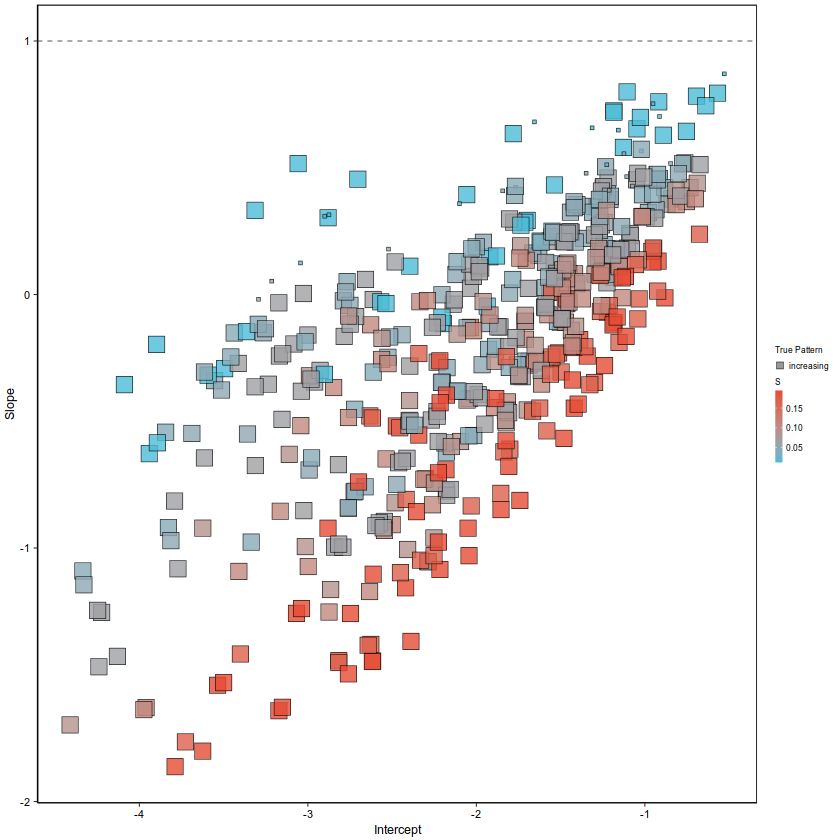

In [24]:
# # S 값으로 색상 표시
p2 <- plot_slope_intercept(for_plot, "S")
print(p2)


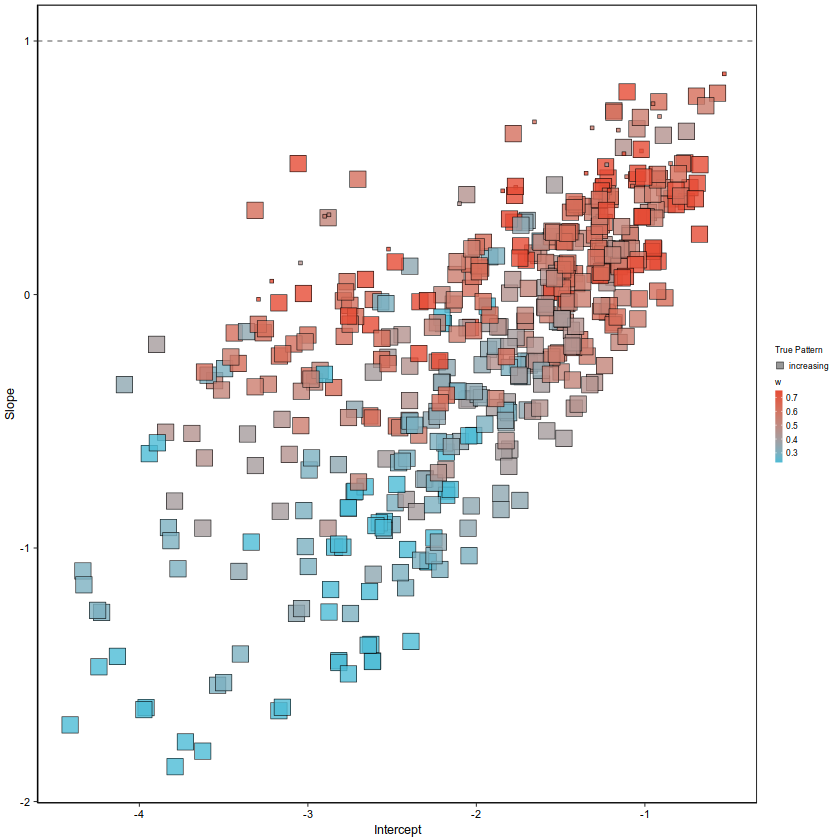

In [25]:
# w 값으로 색상 표시
p3 <- plot_slope_intercept(for_plot, "w")
print(p3)